In [1]:
import numpy as np  
import pandas as pd  
import statsmodels.api as sm  
import matplotlib.pyplot as plt  
from patsy import dmatrices  
from sklearn.linear_model  import LogisticRegression 
from sklearn.model_selection import train_test_split 
from sklearn  import metrics 
dta = sm.datasets.fair.load_pandas().data    

In [2]:
def getData():
    dta['affair'] = (dta.affairs > 0).astype(int)  
    y, X = dmatrices('affair ~ rate_marriage + age + yrs_married + children + religious + educ + C(occupation) + C(occupation_husb)',  dta, return_type="dataframe")   
    X = X.rename(columns = {'C(occupation)[T.2.0]':'occ_2','C(occupation)[T.3.0]':'occ_3','C(occupation)[T.4.0]':'occ_4',  'C(occupation)[T.5.0]':'occ_5',  'C(occupation)[T.6.0]':'occ_6',  'C(occupation_husb)[T.2.0]':'occ_husb_2',  'C(occupation_husb)[T.3.0]':'occ_husb_3',  'C(occupation_husb)[T.4.0]':'occ_husb_4',  'C(occupation_husb)[T.5.0]':'occ_husb_5',  'C(occupation_husb)[T.6.0]':'occ_husb_6'})  
    y = np.ravel(y) 
    X=pd.DataFrame(X)
    y=pd.DataFrame(y)
    inputData=pd.concat([X,dta['affair']],axis=1)
    initData=inputData
    return inputData,initData
data,initData = getData()
uniqueId = ""
target = "affair"
features = ["occ_2","occ_3","occ_4","occ_5","occ_6","occ_husb_2","occ_husb_3","occ_husb_4","occ_husb_5","occ_husb_6","rate_marriage","age","yrs_married","children","religious","educ"] 
testsize=0.2

In [3]:
if(uniqueId==""):
    uniqueId=uniqueId
    uniqueIdGenerator=np.arange(1,len(data))
    UqId=pd.DataFrame(list(uniqueIdGenerator),columns=["UniqueId"])
    #data=pd.concat([UqId,data],axis=1) 
    initData=pd.concat([UqId,data],axis=1) 
    uniqueId=initData.columns[0]
print(initData.head(10))

   UniqueId  Intercept  occ_2  occ_3  occ_4  occ_5  occ_6  occ_husb_2  \
0       1.0        1.0    1.0    0.0    0.0    0.0    0.0         0.0   
1       2.0        1.0    0.0    1.0    0.0    0.0    0.0         0.0   
2       3.0        1.0    0.0    1.0    0.0    0.0    0.0         0.0   
3       4.0        1.0    0.0    0.0    0.0    1.0    0.0         0.0   
4       5.0        1.0    0.0    1.0    0.0    0.0    0.0         0.0   
5       6.0        1.0    0.0    1.0    0.0    0.0    0.0         0.0   
6       7.0        1.0    0.0    0.0    0.0    1.0    0.0         0.0   
7       8.0        1.0    1.0    0.0    0.0    0.0    0.0         0.0   
8       9.0        1.0    0.0    1.0    0.0    0.0    0.0         0.0   
9      10.0        1.0    0.0    1.0    0.0    0.0    0.0         0.0   

   occ_husb_3  occ_husb_4  occ_husb_5  occ_husb_6  rate_marriage   age  \
0         0.0         0.0         1.0         0.0            3.0  32.0   
1         0.0         1.0         0.0         0.

In [4]:
#Python method for handling nan values
#Numerical columns replaced with mean
#String columns replaced with mode
from collections import Counter
def dataCleaning(inputData,features,uniqueId,target):
    updatedData =  inputData[target]   
    dataForClean=pd.DataFrame()
    for i in range(0,len(features)):
        dataForClean=pd.concat([dataForClean,pd.DataFrame(inputData[features[i]])],axis=1)
    dataForClean=pd.concat([dataForClean,pd.DataFrame(inputData[target])],axis=1)
    inputData=dataForClean
    for i in range(0,len(inputData.columns)):
        colName=inputData.columns[i]
        if( (inputData[colName].dtype.name=="object" and inputData[colName].dtype.name!= target) and colName != uniqueId):
            mode=Counter(inputData[colName])
            modeval= mode.most_common(1)[0][0]
            inputData[colName]= inputData[colName].replace(np.NaN, modeval)
        else:
            inputData[colName]= inputData[colName].replace(np.NaN, np.mean(inputData[colName]))

    
    return inputData,updatedData

data,updatedData=dataCleaning(data,features,uniqueId,target)
print(data.head(10))

   occ_2  occ_3  occ_4  occ_5  occ_6  occ_husb_2  occ_husb_3  occ_husb_4  \
0    1.0    0.0    0.0    0.0    0.0         0.0         0.0         0.0   
1    0.0    1.0    0.0    0.0    0.0         0.0         0.0         1.0   
2    0.0    1.0    0.0    0.0    0.0         0.0         0.0         0.0   
3    0.0    0.0    0.0    1.0    0.0         0.0         0.0         0.0   
4    0.0    1.0    0.0    0.0    0.0         0.0         0.0         1.0   
5    0.0    1.0    0.0    0.0    0.0         0.0         0.0         1.0   
6    0.0    0.0    0.0    1.0    0.0         0.0         0.0         1.0   
7    1.0    0.0    0.0    0.0    0.0         0.0         1.0         0.0   
8    0.0    1.0    0.0    0.0    0.0         0.0         1.0         0.0   
9    0.0    1.0    0.0    0.0    0.0         0.0         0.0         0.0   

   occ_husb_5  occ_husb_6  rate_marriage   age  yrs_married  children  \
0         1.0         0.0            3.0  32.0          9.0       3.0   
1         0.0    

In [5]:
#Python method for pre-processing the data
#Categorical variables are label and one hot encoded
def dataPreProcess(inputData,target):
    from sklearn import preprocessing 
    labelencoder= preprocessing.LabelEncoder()
    onehotencoder = preprocessing.OneHotEncoder(sparse=False)
    notencoded = pd.DataFrame()
    encoded = pd.DataFrame()
    colNames=[]
    for i in range(0,len(inputData.columns)):
        colNames.append(inputData.columns[i])
        
    for i in range(0,len(colNames)):
        colName=colNames[i]
        if( (inputData[colName].dtype.name=="object" and inputData[colName].dtype.name!= target) and colNames[i] != uniqueId):
            df =  labelencoder.fit_transform(inputData[colName])
            df = np.array(inputData[colName])
            df =   df.reshape(len(df),1)
            onehot_encoded = onehotencoder.fit_transform(df)
            onehot_encoded = pd.DataFrame(onehot_encoded)
            #onehot_encoded = onehot_encoded.drop(len(onehot_encoded.columns)-1,axis=1)
            encoded=pd.concat([onehot_encoded,encoded],axis=1)       
        else:
            notencoded=  pd.concat([notencoded,inputData[colName]],axis=1)
    combinedData=pd.concat([encoded,notencoded],axis=1)
    updatedData=pd.DataFrame()
    updatedData=pd.concat([updatedData,combinedData],axis=1) 
    Y = pd.DataFrame() 
    Y = pd.DataFrame(updatedData[target])
    del updatedData[target]
    X = pd.DataFrame()
    X = updatedData
   
    return X,Y

X,Y=dataPreProcess(data,target)
print(X.head(10))
print(Y.head(10))

   occ_2  occ_3  occ_4  occ_5  occ_6  occ_husb_2  occ_husb_3  occ_husb_4  \
0    1.0    0.0    0.0    0.0    0.0         0.0         0.0         0.0   
1    0.0    1.0    0.0    0.0    0.0         0.0         0.0         1.0   
2    0.0    1.0    0.0    0.0    0.0         0.0         0.0         0.0   
3    0.0    0.0    0.0    1.0    0.0         0.0         0.0         0.0   
4    0.0    1.0    0.0    0.0    0.0         0.0         0.0         1.0   
5    0.0    1.0    0.0    0.0    0.0         0.0         0.0         1.0   
6    0.0    0.0    0.0    1.0    0.0         0.0         0.0         1.0   
7    1.0    0.0    0.0    0.0    0.0         0.0         1.0         0.0   
8    0.0    1.0    0.0    0.0    0.0         0.0         1.0         0.0   
9    0.0    1.0    0.0    0.0    0.0         0.0         0.0         0.0   

   occ_husb_5  occ_husb_6  rate_marriage   age  yrs_married  children  \
0         1.0         0.0            3.0  32.0          9.0       3.0   
1         0.0    

In [6]:
def datasplit(X,Y,size):
    from sklearn.model_selection import train_test_split
    X_train, X_test, Y_train, Y_test = train_test_split( X, Y, test_size=size, shuffle=False)
    return X_train, X_test, Y_train, Y_test
X_train, X_test, Y_train, Y_test=datasplit(X,Y,testsize)
print(X_train.head(5))
print(X_test.head(5))
print(Y_train.head(5))
print(Y_test.head(5))

   occ_2  occ_3  occ_4  occ_5  occ_6  occ_husb_2  occ_husb_3  occ_husb_4  \
0    1.0    0.0    0.0    0.0    0.0         0.0         0.0         0.0   
1    0.0    1.0    0.0    0.0    0.0         0.0         0.0         1.0   
2    0.0    1.0    0.0    0.0    0.0         0.0         0.0         0.0   
3    0.0    0.0    0.0    1.0    0.0         0.0         0.0         0.0   
4    0.0    1.0    0.0    0.0    0.0         0.0         0.0         1.0   

   occ_husb_5  occ_husb_6  rate_marriage   age  yrs_married  children  \
0         1.0         0.0            3.0  32.0          9.0       3.0   
1         0.0         0.0            3.0  27.0         13.0       3.0   
2         1.0         0.0            4.0  22.0          2.5       0.0   
3         1.0         0.0            4.0  37.0         16.5       4.0   
4         0.0         0.0            5.0  27.0          9.0       1.0   

   religious  educ  
0        3.0  17.0  
1        1.0  14.0  
2        1.0  16.0  
3        3.0  16.0  

In [7]:
def logisticRegression(X_train, X_test, Y_train, Y_test):
    from sklearn.linear_model import LogisticRegression
    regressor = LogisticRegression()
    regressor.fit(X_train,Y_train)        
    predictions = regressor.predict(X_test)
    score = regressor.score(X_test, Y_test)
    from sklearn import metrics       
    cm = metrics.confusion_matrix(Y_test, predictions)
    return predictions,score,cm

In [8]:
predictions,score,cm=logisticRegression(X_train, X_test, Y_train, Y_test)
n=len(data)
p=len(features)
adjr= 1-(1-score)*(n-1)/(n-p-1)
output1=pd.DataFrame(list(Y_test[target]),columns=["Actual"])
output2=pd.DataFrame(list(predictions),columns=["Predicted"])
prednactual=pd.concat([output1,output2],axis=1)
testStart=initData[uniqueId][len(X_train):len(data)]
testStart=pd.DataFrame(testStart,columns=[uniqueId])
testStart.reset_index(drop=True, inplace=True)
prednactual.reset_index(drop=True, inplace=True)
prednactualfinal=pd.concat([testStart,prednactual],axis=1)
truePositive = cm[0,0]
falsePositive= cm[1,0]
trueNegative= cm[1,1]
falseNegative=cm[0,1]
accuracy= (truePositive + trueNegative) / (truePositive+falsePositive+trueNegative+falseNegative)
precision= (truePositive) /(truePositive + falsePositive)
recall=   (truePositive) /(truePositive+falseNegative)
f1score= (2*precision*recall) / (precision+recall)

print(".........InputData............")
print(initData.head(5))

print(".............Unique and target variables..............")
print("UniqueId: ",uniqueId)
print("Target variable: ",target)

print(".........Input Data............")
print(data.head(5))


print(".........Output Data............")
print(prednactualfinal.head(5))

print(".............Evaluation metrics..............")
print("Accuracy: ",score)
print("cm: ",cm)
print("Precision: ",precision)
print("Recall: ",recall)
print("F1Score: ",f1score)

.........InputData............
   UniqueId  Intercept  occ_2  occ_3  occ_4  occ_5  occ_6  occ_husb_2  \
0       1.0        1.0    1.0    0.0    0.0    0.0    0.0         0.0   
1       2.0        1.0    0.0    1.0    0.0    0.0    0.0         0.0   
2       3.0        1.0    0.0    1.0    0.0    0.0    0.0         0.0   
3       4.0        1.0    0.0    0.0    0.0    1.0    0.0         0.0   
4       5.0        1.0    0.0    1.0    0.0    0.0    0.0         0.0   

   occ_husb_3  occ_husb_4  occ_husb_5  occ_husb_6  rate_marriage   age  \
0         0.0         0.0         1.0         0.0            3.0  32.0   
1         0.0         1.0         0.0         0.0            3.0  27.0   
2         0.0         0.0         1.0         0.0            4.0  22.0   
3         0.0         0.0         1.0         0.0            4.0  37.0   
4         0.0         1.0         0.0         0.0            5.0  27.0   

   yrs_married  children  religious  educ  affair  
0          9.0       3.0        3

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


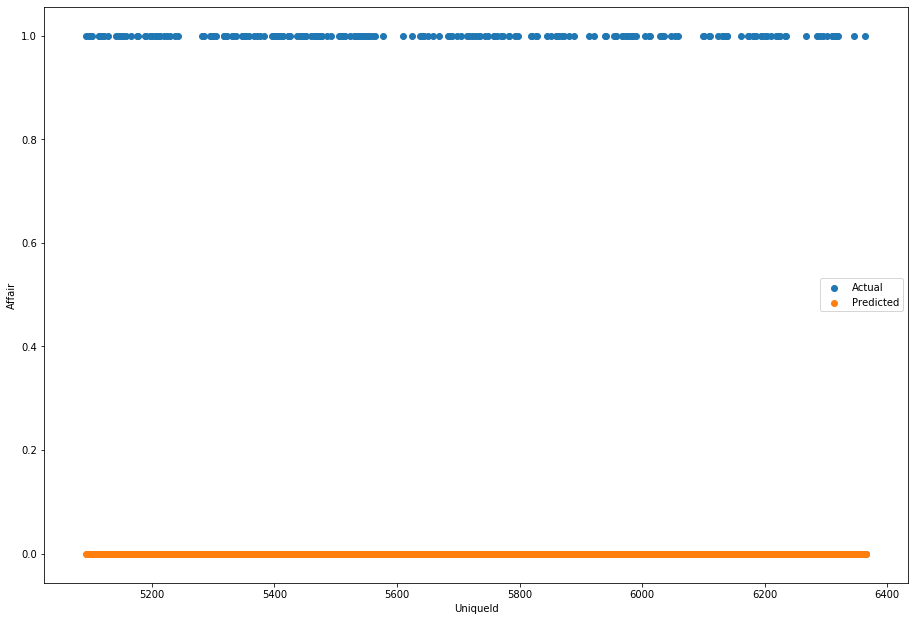

In [12]:
import matplotlib.pyplot as plt
fig=plt.figure()
ax = fig.add_axes([0,0,2,2])
y_axis_pred = prednactualfinal["Predicted"]
y_axis_actual = prednactualfinal["Actual"]
x_axis= prednactualfinal[uniqueId]
ax.scatter(x_axis,y_axis_pred)
ax.scatter(x_axis,y_axis_actual)
ax.set_xlabel("UniqueId")
ax.set_ylabel("Affair")
ax.legend(labels=['Actual', 'Predicted'])
plt.show()